Epoch [1/5], Simple Model Test Accuracy: 94.28%
Epoch [2/5], Simple Model Test Accuracy: 95.90%
Epoch [3/5], Simple Model Test Accuracy: 96.97%
Epoch [4/5], Simple Model Test Accuracy: 97.02%
Epoch [5/5], Simple Model Test Accuracy: 96.17%
Epoch [1/5], Batchensemble Model Test Accuracy: 97.02%
Epoch [2/5], Batchensemble Model Test Accuracy: 97.49%
Epoch [3/5], Batchensemble Model Test Accuracy: 97.70%
Epoch [4/5], Batchensemble Model Test Accuracy: 97.67%
Epoch [5/5], Batchensemble Model Test Accuracy: 97.86%


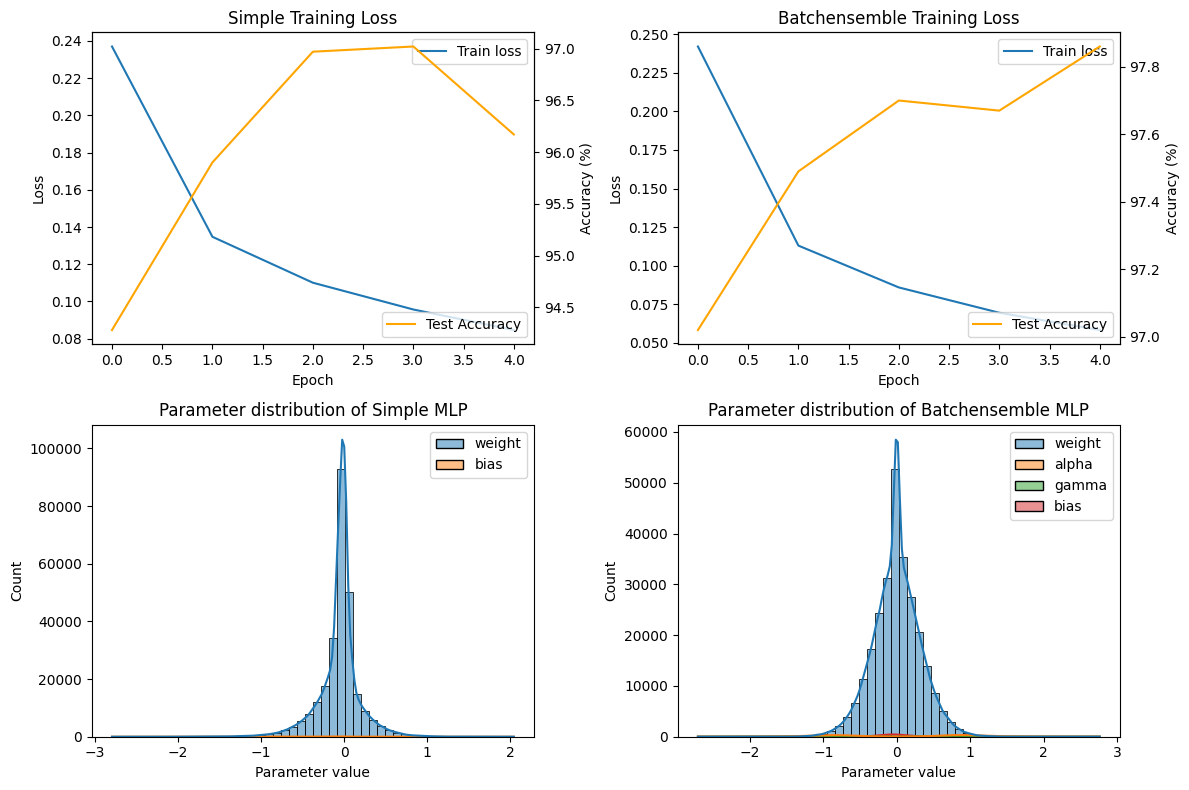

Epoch [1/5], Simple Model Test Accuracy: 98.20%
Epoch [2/5], Simple Model Test Accuracy: 98.66%
Epoch [3/5], Simple Model Test Accuracy: 98.37%
Epoch [4/5], Simple Model Test Accuracy: 98.82%
Epoch [5/5], Simple Model Test Accuracy: 98.88%
Epoch [1/5], Batchensemble Model Test Accuracy: 98.02%
Epoch [2/5], Batchensemble Model Test Accuracy: 98.67%
Epoch [3/5], Batchensemble Model Test Accuracy: 98.76%
Epoch [4/5], Batchensemble Model Test Accuracy: 98.98%
Epoch [5/5], Batchensemble Model Test Accuracy: 99.01%


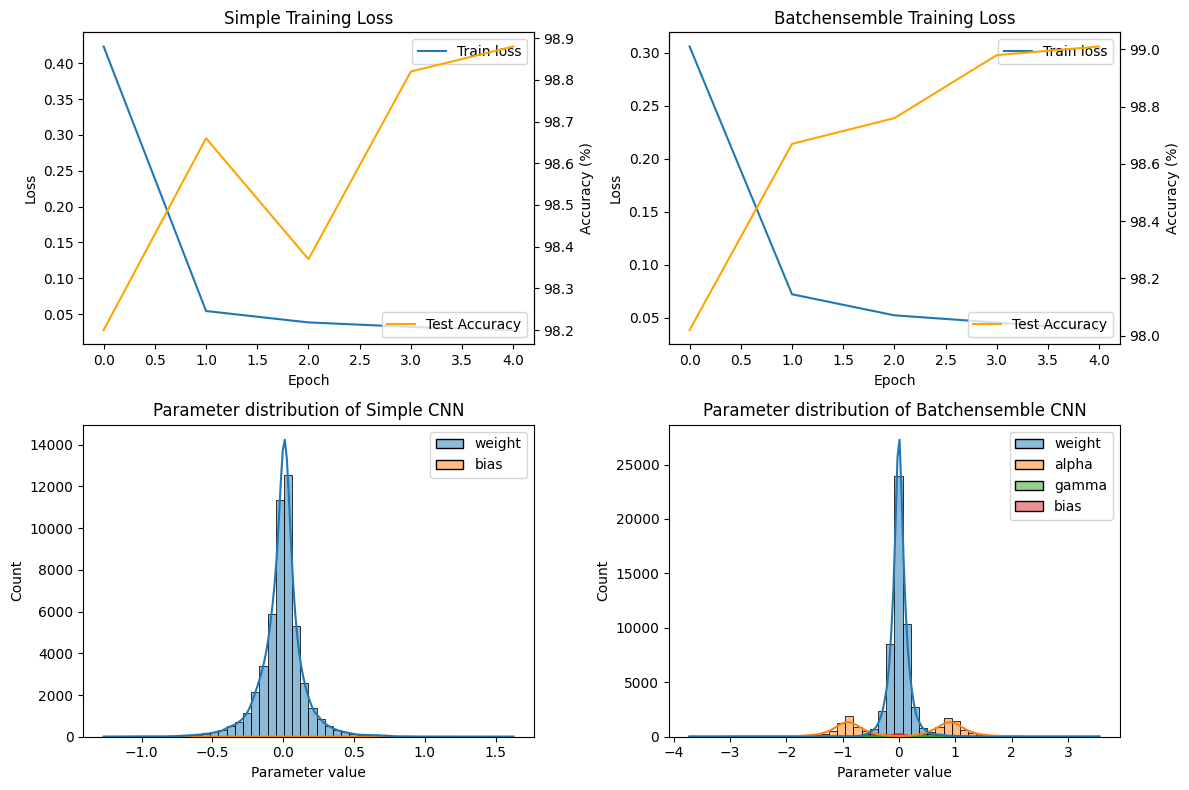

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Iterable
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim

# BatchEnsemble implementation

def random_sign_(tensor: torch.Tensor, prob: float = 0.5, value: float = 1.0):
    """
    Randomly set elements of the input tensor to either +value or -value.
    """
    sign = torch.where(torch.rand_like(tensor) < prob, 1.0, -1.0)
    with torch.no_grad():
        tensor.copy_(sign * value)

class BatchEnsembleMixin:
    def init_ensemble(
        self,
        in_features: int,
        out_features: int,
        ensemble_size: int,
        alpha_init: float | None = None,
        gamma_init: float | None = None,
        bias: bool = True,
        device=None,
        dtype=None,
    ):
        self.ensemble_size = ensemble_size
        self.alpha_init = alpha_init
        self.gamma_init = gamma_init

        if not isinstance(self, nn.Module):
            raise TypeError("BatchEnsembleMixin must be mixed with nn.Module or one of its subclasses")

        if alpha_init is None:
            self.register_parameter("alpha_param", None)
        else:
            self.alpha_param = self.init_scaling_parameter(alpha_init, in_features, device=device, dtype=dtype)
            self.register_parameter("alpha_param", self.alpha_param)

        if gamma_init is None:
            self.register_parameter("gamma_param", None)
        else:
            self.gamma_param = self.init_scaling_parameter(gamma_init, out_features, device=device, dtype=dtype)
            self.register_parameter("gamma_param", self.gamma_param)

        if bias:
            self.bias_param = nn.Parameter(torch.zeros(ensemble_size, out_features, device=device, dtype=dtype))
            self.register_parameter("bias_param", self.bias_param)
        else:
            self.register_parameter("bias_param", None)

    def init_scaling_parameter(self, init_value: float, num_features: int, device=None, dtype=None):
        param = torch.empty(self.ensemble_size, num_features, device=device, dtype=dtype)
        if init_value < 0:
            param.normal_(mean=1, std=-init_value)
        else:
            random_sign_(param, prob=init_value, value=1.0)
        return nn.Parameter(param)

    def expand_param(self, x: torch.Tensor, param: torch.Tensor):
        num_repeats = x.size(0) // self.ensemble_size
        expanded_param = torch.repeat_interleave(param, num_repeats, dim=0)
        extra_dims = len(x.shape) - len(expanded_param.shape)
        for _ in range(extra_dims):
            expanded_param = expanded_param.unsqueeze(-1)
        return expanded_param

class BELinear(nn.Linear, BatchEnsembleMixin):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        device=None,
        dtype=None,
        ensemble_size: int = 1,
        alpha_init: float | None = None,
        gamma_init: float | None = None,
    ):
        nn.Linear.__init__(self, in_features, out_features, bias=False, device=device, dtype=dtype)
        self.init_ensemble(in_features, out_features, ensemble_size, alpha_init, gamma_init, bias)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        if self.alpha_init is not None:
            input = input * self.expand_param(input, self.alpha_param)
        x = F.linear(input, self.weight)
        if self.gamma_init is not None:
            x = x * self.expand_param(x, self.gamma_param)
        if self.bias_param is not None:
            x = x + self.expand_param(x, self.bias_param)
        return x

class Conv2d(nn.Conv2d, BatchEnsembleMixin):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias: bool = True,
        padding_mode='zeros',
        device=None,
        dtype=None,
        ensemble_size: int = 1,
        alpha_init: float | None = None,
        gamma_init: float | None = None,
    ):
        nn.Conv2d.__init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,  # Bias is managed by BatchEnsembleMixin
            padding_mode=padding_mode,
            device=device,
            dtype=dtype
        )
        self.init_ensemble(
            in_features=in_channels,
            out_features=out_channels,
            ensemble_size=ensemble_size,
            alpha_init=alpha_init,
            gamma_init=gamma_init,
            bias=bias,
            device=device,
            dtype=dtype
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        if self.alpha_init is not None:
            input = input * self.expand_param(input, self.alpha_param)
        x = self._conv_forward(input, self.weight, None)
        if self.gamma_init is not None:
            x = x * self.expand_param(x, self.gamma_param)
        if self.bias_param is not None:
            x = x + self.expand_param(x, self.bias_param)
        return x

class BatchNorm2d(nn.BatchNorm2d):
    def __init__(
        self,
        num_features: int,
        eps=1e-5,
        momentum=0.1,
        affine=False,  # We will manage affine parameters ourselves
        track_running_stats=True,
        device=None,
        dtype=None,
        ensemble_size: int = 1,
    ):
        super().__init__(
            num_features,
            eps=eps,
            momentum=momentum,
            affine=affine,
            track_running_stats=track_running_stats,
            device=device,
            dtype=dtype
        )
        self.ensemble_size = ensemble_size
        # Use different names to avoid conflicts with the base class
        self.weight_be = nn.Parameter(torch.Tensor(ensemble_size, num_features))
        self.bias_be = nn.Parameter(torch.Tensor(ensemble_size, num_features))
        self.reset_be_parameters()

    def reset_be_parameters(self):
        nn.init.ones_(self.weight_be)
        nn.init.zeros_(self.bias_be)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # Use the base class's forward method
        x = super().forward(input)
        num_repeats = x.size(0) // self.ensemble_size
        weight = torch.repeat_interleave(self.weight_be, num_repeats, dim=0).unsqueeze(2).unsqueeze(3)
        bias = torch.repeat_interleave(self.bias_be, num_repeats, dim=0).unsqueeze(2).unsqueeze(3)
        x = x * weight + bias
        return x

# StandardScaler
class StandardScaler:
    """
    Based on https://gist.github.com/farahmand-m/8a416f33a27d73a149f92ce4708beb40
    Extended with inverse_transform
    """

    def __init__(
        self,
        mean: torch.Tensor | None = None,
        std: torch.Tensor | None = None,
        epsilon: float = 1e-8,
    ):
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, data: torch.Tensor):
        reduction_axes = list(range(data.dim() - 1))
        self.mean = torch.mean(data, dim=reduction_axes)
        self.std = torch.std(data, dim=reduction_axes)
        return self

    def transform(self, data: torch.Tensor) -> torch.Tensor:
        if self.mean is None or self.std is None:
            raise RuntimeError("Call fit before calling transform.")
        scaled_mean = (data - self.mean) / (self.std + self.epsilon)
        return scaled_mean

    def inverse_transform(self, scaled_data: torch.Tensor) -> torch.Tensor:
        if self.mean is None or self.std is None:
            raise RuntimeError("Call fit before calling inverse_transform.")
        unscaled_mean = scaled_data * (self.std + self.epsilon) + self.mean
        return unscaled_mean

    def fit_transform(self, data: torch.Tensor) -> torch.Tensor:
        self.fit(data)
        return self.transform(data)

    def to(self, target_device: torch.device):
        if self.mean is not None and self.std is not None:
            self.mean = self.mean.to(target_device)
            self.std = self.std.to(target_device)
        return self

# MLP Models for MNIST

class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=256, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

class BatchEnsembleMLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=256, num_classes=10, ensemble_size=4, alpha_gamma_init=0.5):
        super(BatchEnsembleMLP, self).__init__()
        self.ensemble_size = ensemble_size
        self.fc1 = BELinear(
            input_size,
            hidden_size,
            ensemble_size=ensemble_size,
            alpha_init=alpha_gamma_init,
            gamma_init=alpha_gamma_init,
        )
        self.relu = nn.ReLU()
        self.fc2 = BELinear(
            hidden_size,
            hidden_size,
            ensemble_size=ensemble_size,
            alpha_init=alpha_gamma_init,
            gamma_init=alpha_gamma_init,
        )
        self.relu2 = nn.ReLU()
        self.fc3 = BELinear(
            hidden_size,
            num_classes,
            ensemble_size=ensemble_size,
            alpha_init=alpha_gamma_init,
            gamma_init=alpha_gamma_init,
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# CNN Models

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # [batch_size, 32, 28, 28]
        x = self.pool(x)                        # [batch_size, 32, 14, 14]
        x = self.relu(self.bn2(self.conv2(x)))  # [batch_size, 64, 14, 14]
        x = self.pool(x)                        # [batch_size, 64, 7, 7]
        x = x.view(x.size(0), -1)               # [batch_size, 64*7*7]
        x = self.fc(x)                          # [batch_size, 10]
        return x

class BatchEnsembleCNN(nn.Module):
    def __init__(self, ensemble_size=4, alpha_gamma_init=0.5):
        super(BatchEnsembleCNN, self).__init__()
        self.ensemble_size = ensemble_size
        self.conv1 = Conv2d(1, 32, kernel_size=3, padding=1,
                            ensemble_size=ensemble_size,
                            alpha_init=alpha_gamma_init,
                            gamma_init=alpha_gamma_init)
        self.bn1 = BatchNorm2d(32, ensemble_size=ensemble_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = Conv2d(32, 64, kernel_size=3, padding=1,
                            ensemble_size=ensemble_size,
                            alpha_init=alpha_gamma_init,
                            gamma_init=alpha_gamma_init)
        self.bn2 = BatchNorm2d(64, ensemble_size=ensemble_size)
        self.fc = BELinear(64 * 7 * 7, 10,
                           ensemble_size=ensemble_size,
                           alpha_init=alpha_gamma_init,
                           gamma_init=alpha_gamma_init)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))   # [batch_size * ensemble_size, 32, 28, 28]
        x = self.pool(x)                         # [batch_size * ensemble_size, 32, 14, 14]
        x = self.relu(self.bn2(self.conv2(x)))   # [batch_size * ensemble_size, 64, 14, 14]
        x = self.pool(x)                         # [batch_size * ensemble_size, 64, 7, 7]
        x = x.view(x.size(0), -1)                # [batch_size * ensemble_size, 64*7*7]
        x = self.fc(x)                           # [batch_size * ensemble_size, 10]
        return x

# Training and visualization functions

def train_mnist_model(
    model,
    train_loader,
    test_loader,
    model_type="simple",
    ensemble_size=1,
    num_epochs=5,
    lr=0.01,
):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            if model_type == "batchensemble":
                images = images.repeat(ensemble_size, 1, 1, 1)
                labels = labels.repeat(ensemble_size)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        # Evaluate model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                if model_type == "batchensemble":
                    images = images.repeat(ensemble_size, 1, 1, 1)
                    outputs = model(images)
                    outputs = outputs.view(ensemble_size, -1, 10)
                    outputs = outputs.mean(dim=0)
                else:
                    outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], {model_type.capitalize()} Model Test Accuracy: {test_accuracy:.2f}%')

    return train_losses, test_accuracies

def plot_training_results(train_losses, test_accuracies, ax, model_type="simple"):
    ax.plot(train_losses, label="Train loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(f"{model_type.capitalize()} Training Loss")
    ax.legend()

    ax2 = ax.twinx()
    ax2.plot(test_accuracies, label="Test Accuracy", color="orange")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend(loc='lower right')

@torch.no_grad()
def plot_parameters(model, ax, model_name="Model"):
    # Flatten all parameters, then plot in descending order
    params = []
    tags = []
    for name, param in model.named_parameters():
        if "bias" in name:
            tag = "bias"
        elif "alpha" in name:
            tag = "alpha"
        elif "gamma" in name:
            tag = "gamma"
        elif "weight" in name:
            tag = "weight"
        else:
            tag = "unknown"
        params.append(param.detach().cpu().flatten())
        tags += [tag] * param.numel()
    params = torch.cat(params).numpy()
    sns.histplot(x=params, hue=tags, ax=ax, kde=True, bins=50)
    ax.set_xlabel("Parameter value")
    ax.set_ylabel("Count")
    ax.set_title(f"Parameter distribution of {model_name}")

# Main function

def main():
    # Set random seed
    seed = 42
    torch.manual_seed(seed)

    # Hyperparameters
    ensemble_size = 4
    alpha_gamma_init = 0.5
    num_epochs = 5
    batch_size = 128
    lr = 0.01

    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load MNIST dataset
    train_dataset = datasets.MNIST(root='./data', train=True,
                                   download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False,
                                  download=True, transform=transform)

    # Adjust batch size to be multiple of ensemble_size
    assert batch_size % ensemble_size == 0, "Batch size must be divisible by ensemble size."

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    # Build MLP models
    mlp_models = {}
    mlp_train_losses = {}
    mlp_test_accuracies = {}
    model_types = ["simple", "batchensemble"]
    for model_type in model_types:
        if model_type == "simple":
            model = MLP()
            ensemble_size_mlp = 1
        elif model_type == "batchensemble":
            model = BatchEnsembleMLP(
                ensemble_size=ensemble_size,
                alpha_gamma_init=alpha_gamma_init
            )
            ensemble_size_mlp = ensemble_size
        else:
            raise ValueError("Invalid model_type. Choose 'simple' or 'batchensemble'")
        mlp_models[model_type] = model
        tr_losses, te_accuracies = train_mnist_model(
            model,
            train_loader,
            test_loader,
            model_type=model_type,
            ensemble_size=ensemble_size_mlp,
            num_epochs=num_epochs,
            lr=lr,
        )
        mlp_train_losses[model_type] = tr_losses
        mlp_test_accuracies[model_type] = te_accuracies

    # Plot MLP results
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    for i, model_type in enumerate(model_types):
        plot_training_results(mlp_train_losses[model_type], mlp_test_accuracies[model_type], axs[0, i], model_type=model_type)
        plot_parameters(mlp_models[model_type], axs[1, i], model_name=f"{model_type.capitalize()} MLP")

    plt.tight_layout()
    plt.show()

    # Build CNN models
    cnn_models = {}
    cnn_train_losses = {}
    cnn_test_accuracies = {}
    model_types = ["simple", "batchensemble"]
    for model_type in model_types:
        if model_type == "simple":
            model = SimpleCNN()
            ensemble_size_cnn = 1
        elif model_type == "batchensemble":
            model = BatchEnsembleCNN(
                ensemble_size=ensemble_size,
                alpha_gamma_init=alpha_gamma_init
            )
            ensemble_size_cnn = ensemble_size
        else:
            raise ValueError("Invalid model_type. Choose 'simple' or 'batchensemble'")
        cnn_models[model_type] = model
        tr_losses, te_accuracies = train_mnist_model(
            model,
            train_loader,
            test_loader,
            model_type=model_type,
            ensemble_size=ensemble_size_cnn,
            num_epochs=num_epochs,
            lr=lr,
        )
        cnn_train_losses[model_type] = tr_losses
        cnn_test_accuracies[model_type] = te_accuracies

    # Plot CNN results
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    for i, model_type in enumerate(model_types):
        plot_training_results(cnn_train_losses[model_type], cnn_test_accuracies[model_type], axs[0, i], model_type=model_type)
        plot_parameters(cnn_models[model_type], axs[1, i], model_name=f"{model_type.capitalize()} CNN")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
